- なんかよくわからないバグが残っている
- 総和がEに比例して増えるが，なぜか1/2*Eくらい？

In [ ]:
!pip install japanize-matplotlib nptyping &>/dev/null && wait $PID # pyplot用日本語フォント，Numpy用型ヒント
from matplotlib import pylab as plt
import japanize_matplotlib

import numpy as np
import pandas as pd

from pprint import pprint as pprint
from typing import Callable, List, Dict, Tuple, Any
from nptyping import NDArray, Float

##フィッティングに使うもの
from scipy.optimize import curve_fit
import numpy as np
import seaborn as sns ## 図

def loadData():
    #Googleコミュニティーモビリティーレポートはソースと同じフォルダ以下のMobility_Report/2021_JP_Region_Mobility_Report.csvとして置いてある
    url='/content/drive/MyDrive/Colab Notebooks/Mobility_Report/2021_JP_Region_Mobility_Report.csv'
    #df=pd.read_csv(url, index_col=8, usecols=['date','retail_and_recreation_percent_change_from_baseline'], parse_dates=[8])
    df=pd.read_csv(url)
    df=df[df['sub_region_1'].str.contains('Tokyo',na=False)]
    val=df.residential_percent_change_from_baseline.values

    val=np.convolve(val, np.ones(7,dtype=np.float64), mode='same')#移動平均
    val=np.log10(val)
    val=(val-np.average(val))/(np.std(val)*3)+1.0

    #print("df.shape",df.shape)
    return val.tolist()[0:-3]

def loadPositivesData():
    #Googleコミュニティーモビリティーレポートはソースと同じフォルダ以下のMobility_Report/2021_JP_Region_Mobility_Report.csvとして置いてある
    #from google.colab import drive
    #drive.mount('/content/drive')
    url='https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_positive_cases_by_day_of_symptom_onset.csv'
    df=pd.read_csv(url, index_col=3, parse_dates=[3])
    #df=pd.read_csv(url)
    df=df.loc['2021-01-01':'2021-06-14']
    val=df['陽性者数']

    #print("df.shape",df.shape)
    import copy
    return copy.copy(val.astype(np.float64))

def floor2(v):
    import math
    n=2  # 小数点以下n位
    return math.floor(v * 10 ** n) / (10 ** n)

def floor2str(v):
    return str(floor2(v))

sum= 0.9870468781408267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


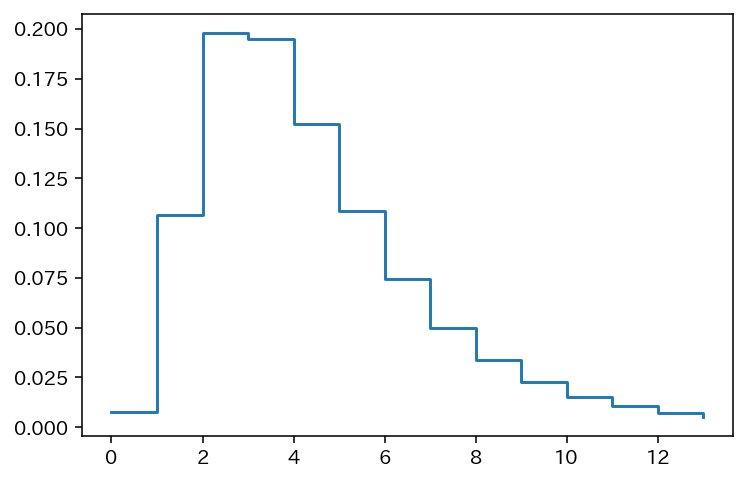

[0.007616162393935755,
 0.10661564591285894,
 0.19811118537283112,
 0.19489974050854242,
 0.15248019706849247,
 0.10857769963894148,
 0.07428285201845175,
 0.050046696738792584,
 0.03361272131382531,
 0.022647500299783352,
 0.01535926540933219,
 0.010502653380433213,
 0.007247016702326414,
 0.005047541382279697]
sum= 0.9782103393451957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


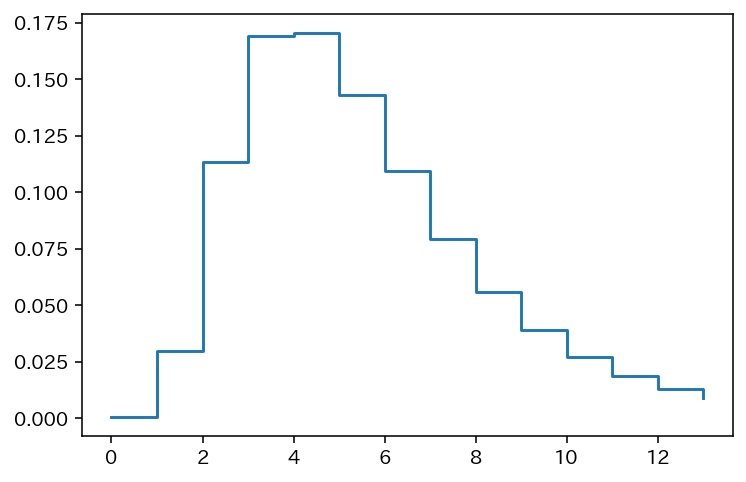

[0.0005570610690246447,
 0.02992844307965209,
 0.11345639970243787,
 0.1690415476517606,
 0.17061499946455339,
 0.14325041542061523,
 0.10939897939384158,
 0.07939468446583153,
 0.056054374640822635,
 0.03901795419817111,
 0.02699026129041493,
 0.018644678183702856,
 0.01290125928538044,
 0.008959281498986837]


In [ ]:
import scipy.special as sps
# 世代時間の確率分布
def serial_int(xstart=0,xend=14,xstep=1)->Tuple[range,NDArray[Float]]:
    #https://github.com/aakhmetz/COVID19SerialInterval
    #Lognormal distribution as the best-fit model for certain and probable pairs with right truncation
    param1=1.376
    param2=0.567
    x=np.arange(xstart,xend,xstep)
    lognormcdf = lambda x, mu, sigma: 0.5 + 0.5*sps.erf((np.log(x) - mu)/np.sqrt(2)/sigma)
    y=[np.sum(lognormcdf(xx+xstep,param1,param2)-lognormcdf(xx,param1,param2)) for xx in x]

    #plt.step(x,y,where='post')
    #plt.show()
    return x,y

def serial_int_test():
    ts,pdf=serial_int()
    sum=np.sum(pdf)
    print("sum=",sum)
    plt.step(ts,pdf,where='post')
    plt.show()
    pprint(pdf)

serial_int_test()

def incubation_period(xstart=0,xend=14,xstep=1):
    #https://bmjopen.bmj.com/content/10/8/e039652#DC1
    #mu=1.63 and sigma=0.50
    param1=1.63
    param2=0.50
    x=np.arange(xstart,xend,xstep)
    lognormcdf = lambda x, mu, sigma: 0.5 + 0.5*sps.erf((np.log(x) - mu)/np.sqrt(2)/sigma)
    y=[np.sum(lognormcdf(xx+xstep,param1,param2)-lognormcdf(xx,param1,param2)) for xx in x]

    #plt.step(x,y,where='post')
    #plt.show()
    return x,y


def incubation_period_test():
    ts,pdf=incubation_period()
    sum=np.sum(pdf)
    print("sum=",sum)
    plt.step(ts,pdf,where='post')
    plt.show()
    pprint(pdf)

incubation_period_test()


In [ ]:
GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
VARIANTS=["N501Y"]
Matrix=NDArray[(len(GROUPS),len(VARIANTS)),Float[64]]

class PopulationVariable:
    def __init__(self, name, init_values: Matrix,
                target_and_output_funcs: Dict[Any,List[Callable[[Any],Matrix]]]=None,
                init_d_values: Matrix=None,
                data_container=None) -> None:
                
        self.name=name
        self.values=[init_values.astype(np.float64)]
        self.target_and_output_funcs=target_and_output_funcs
        self.data_container=data_container
        if(init_d_values is not None):
            self.d=[init_d_values.astype(np.float64)]
        else:
            self.d=[np.zeros_like(init_values, dtype=np.float64)]
        self.input=[np.zeros_like(init_values, dtype=np.float64)]
        self.out=[np.zeros_like(init_values, dtype=np.float64)]
        self.correction=[np.zeros_like(init_values, dtype=np.float64)]

        self.values.insert(1,np.copy(self.values[0]))
        self.d.insert(1,np.zeros_like(self.d[0]))
        self.out.insert(1,np.zeros_like(self.out[0]))
        self.input.insert(1,np.zeros_like(self.input[0]))
        self.correction.insert(1,np.zeros_like(self.correction[0]))


    # 入力を受け入れて，values[t]に足す
    def add_inflow(self, t, value: Float[64])->None:
        #print(self.name+".add_inflow",t,np.sum(value))
        value=value.astype(np.float64)
        self.values[t]+=value
        self.d[t]+=value
        self.input[t]+=value
    
    # valuesとdの先頭を追加する．
    # あらかじめtarget_and_output_funcsに登録されている各targetごとの
    # 1) 出力関数fを呼び，targetごとの流出量を計算
    # 2) target.add_inflow()で出力する
    # 3) 流出量合計をself.valuesとself.dから引く
    def flush(self, t):
        #print(self.name+".flush",t)

        if(self.target_and_output_funcs is not None):
            o={}
            for target, f in self.target_and_output_funcs.items():
                o[target]=f(self, self.data_container, self.values[t-1], t)
                
                #print(self.name+"→"+target.name+".add_inflow",t,np.sum(o[target]))
                target.add_inflow(t, o[target])
                self.values[t]-=o[target]
                self.d[t]-=o[target]
                self.out[t]+=o[target]

            # 負の値が出たときに補正する(その年齢層のみ)
            if(True):
                is_negative=(self.values[t]<=0)
                is_zero=(np.array(self.values[t]==0) & np.array(self.d[t]==0))
                is_negative=is_negative & (~is_zero)
                if(np.any(is_negative)):
                    self.correction[t]=np.copy(self.values[t])
                    self.d[t][is_negative]=-self.values[t][is_negative]
                    self.values[t][is_negative]=0.0
                    self.correction[t]=self.correction[t]-self.values[t]

                    #print(self.name+"→ sum correction["+str(t)+"]=",self.correction[t])
                    for target, f in self.target_and_output_funcs.items():
                        #print(self.name+"→"+target.name+" correction["+str(t)+"]=",self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()]))
                        if(np.sum([vs for vs in o.values()])!=0):
                            #print("Corr. "+self.name+"→"+target.name+".add_inflow",t,np.sum(self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()])))
                            target.add_inflow(t, self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()]))
                        else:
                            #print("Corr. "+self.name+"→"+target.name+".add_inflow",t,np.sum(self.correction[t]))
                            target.add_inflow(t, self.correction[t])
        # init
        if(t+1<len(self.values)):
            self.values[t+1]=np.copy(self.values[t])
            self.d[t+1]=np.zeros_like(self.d[t])
            self.out[t+1]=np.zeros_like(self.d[t])
            self.input[t+1]=np.zeros_like(self.d[t])
            self.correction[t+1]=np.zeros_like(self.values[t])
        else:
            self.values.insert(t+1,np.copy(self.values[t]))
            self.d.insert(t+1,np.zeros_like(self.d[t]))
            self.out.insert(t+1,np.zeros_like(self.d[t]))
            self.input.insert(t+1,np.zeros_like(self.d[t]))
            self.correction.insert(t+1,np.zeros_like(self.values[t]))


In [ ]:
class DataContainer:
    def __init__(self,label=None,dV0=None,R0=None,E0=None,mobility=None):
        self.label=label
        self.NUM_OF_DAYS=170
        #self.NUM_OF_DAYS=365
        self.NUM_OF_CALCULATED_DAYS=0
        self.GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
        
        self.R0=np.array([[1.2]])#1.5--0.9くらいを想定．幅2.4
        if(R0 is not None):
            self.R0=R0
        #1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
        #0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)

        #東京都の人口
        #https://www.bousai.metro.tokyo.lg.jp/_res/projects/default_project/_page_/001/013/860/47kai/2021052704.pdf
        self.N:Matrix=np.array([[524939+499632], # 0-9
                    [493559+566729], # 10-19
                    [753698+863678], # 20-29
                    [969877+1038390], # 30
                    [1154214+1048170], # 40
                    [891332+722755], # 50
                    [725312+854575], # 60
                    [713342+583971], # 70
                    [449314+261441], # 80
                    [108999+28732], # 90
                    [5142]], dtype=np.float)# >=100
        #ゼロベクトル
        self.ZERO=np.zeros_like(self.N, dtype=np.float64)
        #1ベクトル
        self.ONE=self.ZERO+1.0

        self.positives_target=loadPositivesData()

        if(mobility is not None):
            self.label+=",mobility,R0±3σ="+floor2str(self.R0*(np.average(mobility)-np.std(mobility)*3))
            self.label+="〜"+floor2str(self.R0*(np.average(mobility)+np.std(mobility)*3))
            self.mobility=mobility
            #print("R範囲=avg-3σ〜avg+3σ=",self.R0*(np.average(mobility)-np.std(mobility)*3),"〜",self.R0*(np.average(mobility)+np.std(mobility)*3))
            #print("np.average(mobility)=",np.average(self.mobility))
            #print("np.std(mobility)*3=",np.std(self.mobility)*3)

            if(self.NUM_OF_DAYS>len(mobility)):
                #与えられたmobilityが短いとき，最後の要素で埋める
                self.mobility=self.mobility+([self.mobility[-1]]*(self.NUM_OF_DAYS-len(mobility)))
        else:
            self.mobility=[1.0]*self.NUM_OF_DAYS
        #print("len(self.mobility)=",len(self.mobility))
        #print("self.NUM_OF_DAYS=",self.NUM_OF_DAYS)

        self.I0:Matrix=np.array([
                    [8], # 0-19
                    [5], # 0-19
                    [30], # 20-
                    [20], # 30-
                    [17], # 40-
                    [12], # 50-
                    [5], # 60-
                    [3], # 70-
                    [1], # 80-
                    [1], # 90-
                    [0]], dtype=np.float)# >=100
        self.I0=self.I0/np.sum(self.I0)*9468 #1/1時点療養中
        # https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000089
        # 全国地方公共団体コード,都道府県名,市区町村名,日付,陽性者数（累計）,入院中,軽症・中等症,重症,宿泊療養,自宅療養,調整中,死亡,退院
        # 130001,東京都,,2021-01-01,60960,2730,2642,88,1013,3278,2447,631,50861
        # 60960-(631+50861)=9468
        # 2730+1013+3278+2447=9468

        self.Q0=np.copy(self.I0)/np.sum(self.I0)*4500 #5/7時点全患者

        # 罹患率10万人あたり https://datastudio.google.com/u/0/reporting/c1dfbd03-0aa7-457d-81d2-3ca5be34706b/page/KNtNB?s=mM99TXFS68A
        # 「同性同世代10万人あたり何人感染しているか。……かかりやすさを比較」
        self.ALPHA=np.array([[413.05+399.74], # 0-9
                        [871.69+749.47], # 10-19
                        [2551.66+2330.63], # 20-29
                        [1821.6+1268.86], # 30
                        [1336.05+842.52], # 40
                        [1249.87+922.23], # 50
                        [945.98+655.33], # 60
                        [748.8+566.84], # 70
                        [952.52+804.37], # 80
                        [1393.54+1336.56], # 90
                        [2597.4+1582.82]], dtype=np.float)# >=100
        self.ALPHA=self.ALPHA/np.sum(self.ALPHA)
        
        #治癒率(I→R，Q→R)
        #self.GAMMA=self.ALPHA*(0.178881340543816720383164524)
        self.GAMMA=self.ALPHA*(1-0.1**(1/10))# #(1-GAMMA)^10=0.2 ⇒ GAMMA=1-0.2^(1/10)．順調な8割は10日目までに排菌が止まり，1割はCに残留する

        #隔離率 I→Q
        self.EPSILON=self.ZERO+0.151657 #I*(1-EPSILON)^10=0.1*I #完治までに10%が隔離されない
        #self.EPSILON=self.ZERO+1/10 #平均10日で発見・隔離される
        #self.EPSILON=self.ZERO+1/1000

        #発症率 E→I
        #self.DELTA=self.ZERO+(1/5.6)
        _,self.DELTA=serial_int()
        
        #重症化率
        self.KAPPA=np.array([
                    [0.5], # <10
                    [0.2], # 10-19
                    [0.3], # 20-29
                    [1], # 30
                    [4], # 40
                    [10], # 50
                    [25], # 60
                    [47], # 70
                    [71], # 80
                    [78], # 90
                    [78]], dtype=np.float)# >=100
        self.KAPPA=self.KAPPA/sum(self.KAPPA)*0.06617624
        #ちなみに大阪5/23-以降の全年齢の重症化率K(t)=dC(t)/I(t-1)=0.06617624
        #重症化しない率(1-p)から: (1-p)/p=5.6, 重症化率p=0.151515

        #重症化後退院率．
        #self.LAMBDA=np.copy(self.ZERO)+(1-0.5**(1/14)) #(1-LAMBDA)^14=0.1 ⇒ LAMBDA=1-0.5^(1/14) 14日で1/10になる
        self.LAMBDA=1/self.KAPPA
        self.LAMBDA=self.KAPPA/np.sum(self.KAPPA)*(1-0.0001**(1/14))

        #感染率(R0=β/γ⇒β=R0γ．Iの減少要因の平均をγの代わりに利用する)
        self.BETA=self.R0*self.GAMMA/self.N #BETA=R0*GAMMA/N (R0の定義より．αは年齢別の係数)

        # Nに対するワクチン接種割合(速度)[-/day]．Nと同じ形の行列np.array()で年齢別に設定．
        self.OMEGA=np.array([[0], # <10
                    [0], # 10-19
                    [1], # 20-29
                    [1], # 30
                    [1], # 40
                    [1], # 50
                    [1], # 60
                    [1], # 70
                    [1], # 80
                    [1], # 90
                    [1]], dtype=np.float64)# >=100
        self.OMEGA=self.OMEGA*self.N #Nの割合
        if(0<np.sum(self.OMEGA)):
            self.OMEGA=self.OMEGA/np.sum(self.OMEGA)
        self.OMEGA=self.OMEGA*((0.37/100)*np.sum(self.N)) #%/day
        #self.OMEGA=self.OMEGA*(1/100)*np.sum(self.N) #1%/day
        #print("self.OMEGA init=",self.OMEGA)
        
        if(dV0 is not None):
            self.OMEGA=dV0
            #print("dV0 is not None: dV0=",dV0)
        self.dV=[np.copy(self.OMEGA)]

        #print("self.dV init=",self.dV[0])

        def StoV(self, d: DataContainer, s: Matrix, t)->Matrix:
            if(len(d.dV)<=t+1):
                d.dV.append(d.dV[t-1])
            else:
                d.dV[t]=d.dV[t-1]

            #Sがマイナスになりそうな世代のdV[t]を0に．傾きを維持する
            is_neg_vec=(s-d.dV[t]<0)
            if(np.any(is_neg_vec)):
                d.dV[t][is_neg_vec]=s[is_neg_vec]
                if(0<np.sum(d.dV[t])):
                    #print("分数:d.dV[t]/np.sum(d.dV[t])*np.sum(d.dV[0])",d.dV[t]/np.sum(d.dV[t])*np.sum(d.dV[0]))
                    d.dV[t]=d.dV[t]/np.sum(d.dV[t])*np.sum(d.dV[0])
            #if(False and t<10):
            #    print("np.sum(s)=",t,np.sum(s))
            #    print("np.sum(v)=",t,np.sum(d.V.values[t-1]))
            #    print("np.sum(dv)=",t,np.sum(d.dV[t]))
            #    print("dv=",t,d.dV[t])
            return np.copy(d.dV[t])

        def StoE(S, d: DataContainer, s: Matrix, t)->Matrix:
            #print(t,"Rt=sum(s*d.BETA*d.mobility[t])=",np.sum(s*d.BETA*d.mobility[t]))
            #print(t,"StoE E=",d.E.values)
            return d.BETA*(d.mobility[t]*np.sum(d.I.values[t-1]))*s

        def EtoI(E, d: DataContainer, e: Matrix, t)->Matrix:
            p=d.ZERO
            for s,delta in enumerate(d.DELTA):# ウィンドウ内の時間s=0〜len(DELTA)
                if(0<=t-s):
                    p+=delta*E.values[t-s]# psitives[t]=pdf[s]*E[t-s]
                    #print(t,"EtoI E.values[",t-s,"]=",sum(E.values[t-s]))
                    #print(t,"delta=",delta,"⊿p[s]=",np.sum(delta*E.values[t-s]))
            d.positives.insert(t+1,p)
            #print(t,"d.E[t]=",np.sum(d.E.values[t:t-14]))
            #print(t,"d.positives[t]=",np.sum(d.positives[t]))
            return d.positives[t]

        def ItoR(I, d: DataContainer, i: Matrix, t)->Matrix:
            return d.GAMMA*i
        
        def ItoC(I, d: DataContainer, i: Matrix, t)->Matrix:
            return d.KAPPA*i

        def ItoQ(I, d: DataContainer, i: Matrix, t)->Matrix:
            return d.EPSILON*i
        
        def CtoR(I, d: DataContainer, c: Matrix, t)->Matrix:
            return d.LAMBDA*c

        def QtoC(Q, d: DataContainer, q: Matrix, t)->Matrix:
            return d.KAPPA*q

        def QtoR(Q, d: DataContainer, q: Matrix, t)->Matrix:
            return d.GAMMA*q

        self.positives=[np.copy(self.ZERO)] #newly quarantined

        self.V=PopulationVariable('V',np.copy(self.ZERO), {}, init_d_values=self.dV[0]) #→出口なし
        self.R=PopulationVariable('R',np.copy(self.ZERO), {}) #→出口なし
        self.C=PopulationVariable('C',np.copy(self.ZERO),
                                  {self.R:CtoR},data_container=self) #critical(severe)
        self.Q=PopulationVariable('Q',np.copy(self.Q0),
                                  {self.C:QtoC, self. R:QtoR}, data_container=self) #quarantined
        self.I=PopulationVariable('I',self.I0,
                                  {self.R:ItoR, self.C:ItoC, self.Q:ItoQ},data_container=self)
        if(E0 is not None):
            self.E=PopulationVariable('E',E0*self.ALPHA,
                                    target_and_output_funcs={self.I:EtoI},data_container=self)
            print("init E:E0=", E0)
            print("init E:self.ALPHA=", self.ALPHA)
        else:
            self.E=PopulationVariable('E',np.copy(self.ZERO),
                                      target_and_output_funcs={self.I:EtoI},data_container=self)
            self.E0=self.E.values[0]
        self.S=PopulationVariable('S',np.copy(self.N),
                                {self.E:StoE, self.V:StoV},data_container=self)

        self.pipeline=[self.S,self.E,self.I,self.Q,self.C,self.R,self.V]
        self.before=[self.S,]
        self.patient=[self.E,self.I,self.Q,self.C]
        self.after=[self.R,self.V]
        
        print("label",self.label)
        #print("N=",self.N)
        #print("np.sum(N)=",np.sum(self.N))
        #print("γ=",self.GAMMA)
        #print("np.sum(γ)=",np.sum(self.GAMMA))
        #print("ε=",self.EPSILON)
        
        #print("α=",self.ALPHA)
        #print("sum(α)=",np.sum(self.ALPHA))

        #print("β*N=(ε+γ+κ)/3*R0*N=",self.BETA*self.N)
        #print("sum(β*N)=",np.sum(self.BETA*self.N/len(self.BETA)))

        #print("κ=",self.KAPPA)
        #print("(大阪5/23-以降の重症化率K(t)=C(t)/I(t-1)=0.06617624)\nsum(κ)/len(κ)=",np.sum(self.KAPPA)/len(self.KAPPA))
        #print("重症化後退院率λ=",self.LAMBDA)

        #print("dV=",self.V.d)
        #print("sum(dV[0])=",np.sum(self.V.d))
        #print("validation sum(self.V.d)/sum(N)=1=",np.sum(self.V.d)/np.sum(self.N))

    def calc(self, T=None):
        if(T is None):
            #T=range(len(self.DELTA),self.NUM_OF_DAYS)
            T=range(self.NUM_OF_DAYS)
        
        for t in T:
            for pvar in self.pipeline:
                pvar.flush(t)

            self.NUM_OF_CALCULATED_DAYS=t
        #print("NUM_OF_CALCULATED_DAYS: ",self.NUM_OF_CALCULATED_DAYS)
        return self

    #fitting
    def fit(self):
        #print("#############fitting#############")
        self.tt=0
        #print(self.tt,"self.positives_target.shape",self.positives_target.shape)
        T=np.array(range(1,len(self.positives_target)))
        self.calc()

        def fitting_model(T, Rratio, DELTAratio):
            self.BETA=self.BETA*Rratio
            self.DELTA=self.DELTA*DELTAratio
            #print(self.tt,"Rratio=",Rratio)
            #print(self.tt,"DELTAratio=", DELTAratio)
            ret=self.calc(T)

            #print("np.array(self.positives,dtype=np.float)=",np.array(self.positives))
            p=np.sum(np.array(ret.positives,dtype=np.float64).reshape(-1,len(GROUPS)),axis=1)
            #print(self.tt,"positives.shape",p.shape)
            #print("err:",self.positives_target-positives)
            self.tt+=1
            return p

        param, cov = curve_fit(fitting_model, T, self.positives_target, maxfev=100000, method="dogbox")
        sns.heatmap(cov)
        
        self.BETA=self.BETA*param[0]
        self.DELTA=self.DELTA*param[1]
        
        return self


In [ ]:
def run():
    #data0=DataContainer(label="0.37%/day接種,R0=1",R0=1).calc()
    #data1=DataContainer(label="0.37%/day接種,R0=1.32",R0=1.32).calc()
    mobility=loadData()

    #mobilityはnp.average()=1，np.std()=1に加工
    if(np.std(mobility)!=0):
        mobility=[(m-np.average(mobility))/(np.std(mobility)*3) for m in mobility]#1.1は適当
        mobility=[m+(np.std(mobility)*3) for m in mobility]
    print("np.average()=",np.average(mobility))
    print("np.std()*3=",np.std(mobility)*3)

    #E[マイナスの時刻]の外挿(back calculation)
    positives_target=loadPositivesData().values
    ts,pdf=serial_int()
    print("list(ts)=",list(ts))
    rev_pdf=np.full_like(pdf,1.0)/pdf[::-1]
    E0=np.sum(positives_target[list(ts)]*rev_pdf)
    print("init positives_target[list(ts)]=",positives_target[list(ts)])
    print("init rev_pdf=",rev_pdf)
    print("init E0=positives_target[list(ts)]*rev_pdf=",positives_target[list(ts)]*rev_pdf)
    print("init sum(E0)=sum(positives_target[list(ts)]*rev_pdf)=",sum(positives_target[list(ts)]*rev_pdf))
    print("init E0=",E0)
    print("init pdf=",pdf)
    #print("init E0*pdf=",E0*pdf)
    #print("init sum(E0*pdf)=",sum(E0*pdf))
    print("init sum(positives_target[list(ts)])=",sum(positives_target[list(ts)]))

    data2=DataContainer(label="接種なし",R0=1.0,E0=np.copy(E0),
        dV0=np.array([[0], # <10
        [0], # 10-19
        [0], # 20-29
        [0], # 30
        [0], # 40
        [0], # 50
        [0], # 60
        [0], # 70
        [0], # 80
        [0], # 90
        [0]]),# >=100
        mobility=mobility
        )

    data1=DataContainer(label="接種なし",R0=0.75,E0=np.copy(E0),
        dV0=np.array([[0], # <10
        [0], # 10-19
        [0], # 20-29
        [0], # 30
        [0], # 40
        [0], # 50
        [0], # 60
        [0], # 70
        [0], # 80
        [0], # 90
        [0]]),# >=100
        mobility=mobility
        )

    dataX=DataContainer(label="接種なし",R0=0.9,E0=np.copy(E0),
        dV0=np.array([[0], # <10
        [0], # 10-19
        [0], # 20-29
        [0], # 30
        [0], # 40
        [0], # 50
        [0], # 60
        [0], # 70
        [0], # 80
        [0], # 90
        [0]]),# >=100
        mobility=mobility
        )

    data0=DataContainer(label="接種なし,R0=1",R0=1,E0=np.copy(E0),
        dV0=np.array([[0], # <10
        [0], # 10-19
        [0], # 20-29
        [0], # 30
        [0], # 40
        [0], # 50
        [0], # 60
        [0], # 70
        [0], # 80
        [0], # 90
        [0]]),# >=100
        )
    #data2=data2.fit()

    datas=[data0,data2]
    for i, d in enumerate(datas):
        datas[i]=d.calc()
    return datas
datas=run()

np.average()= 1.0
np.std()*3= 1.0000000000000002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


list(ts)= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
init positives_target[list(ts)]= [1161. 1296. 1328. 1525. 1396. 1365. 1178. 1040.  962.  900.  902. 1032.
  899.  736.]
init rev_pdf= [198.11625587 137.987815    95.21403438  65.10728042  44.15498341
  29.75064086  19.98133873  13.46205716   9.20999435   6.55822867
   5.13084316   5.04767057   9.37948639 131.29972134]
init E0=positives_target[list(ts)]*rev_pdf= [230012.97306366 178832.20823597 126444.23765085  99288.60263548
  61640.35683944  40609.62476842  23538.01702734  14000.53944808
   8860.01456283   5902.40580287   4628.02052813   5209.19602827
   8432.15826629  96636.59490586]
init sum(E0)=sum(positives_target[list(ts)]*rev_pdf)= 904034.9497634897
init E0= 904034.9497634894
init pdf= [0.007616162393935755, 0.10661564591285894, 0.19811118537283112, 0.19489974050854242, 0.15248019706849247, 0.10857769963894148, 0.07428285201845175, 0.050046696738792584, 0.03361272131382531, 0.022647500299783352, 0.01535926540933219, 0.0105

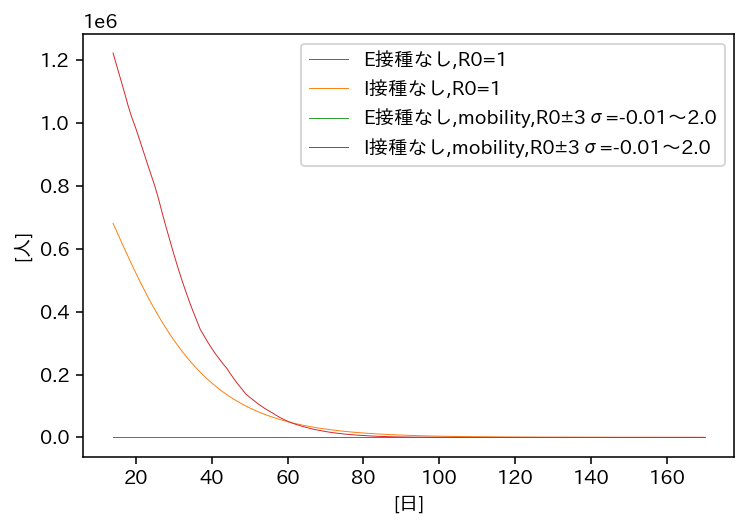

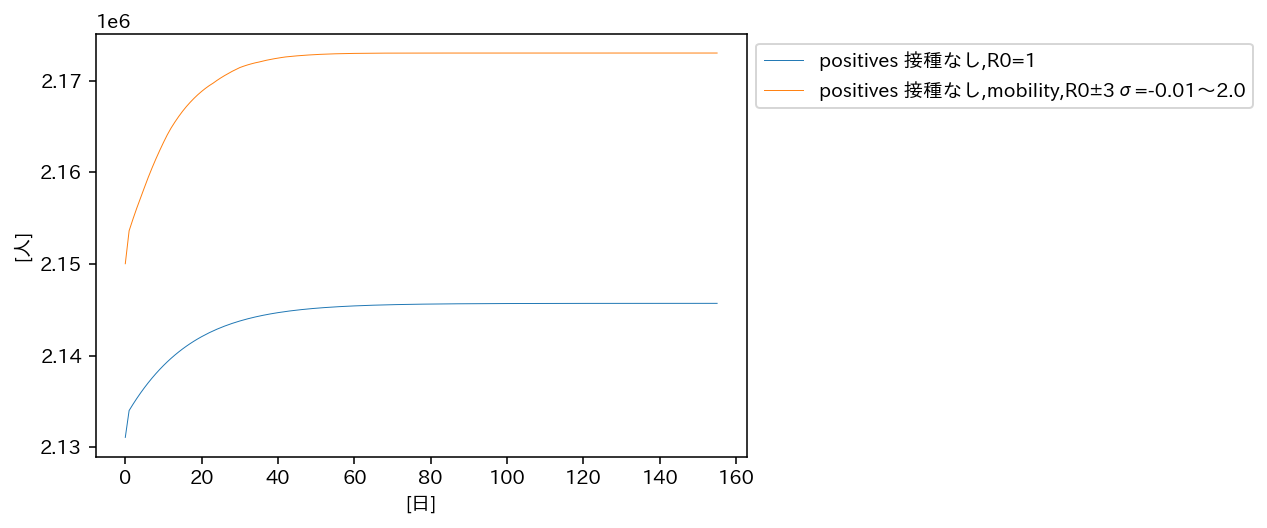

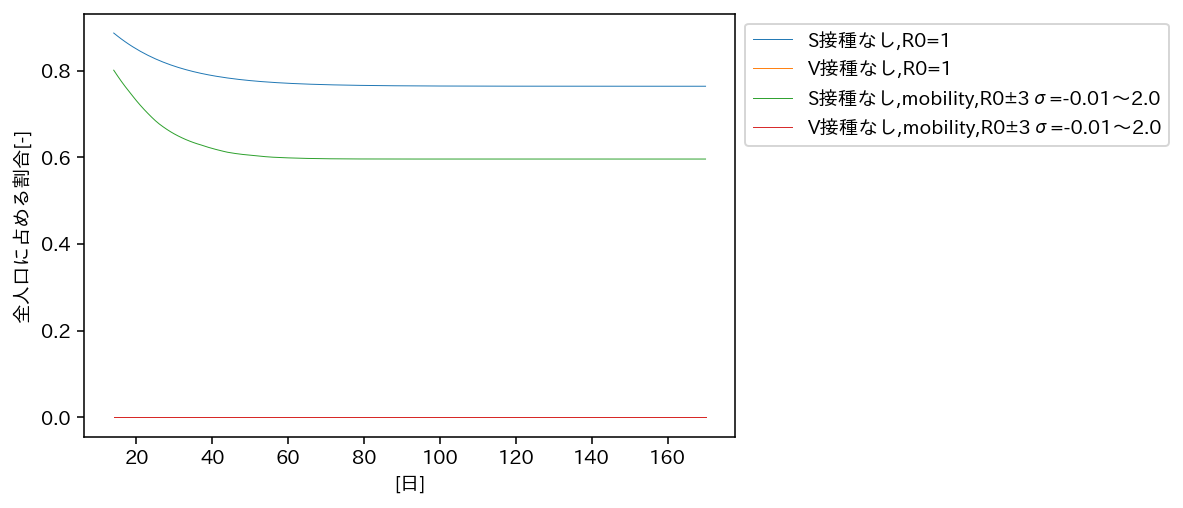

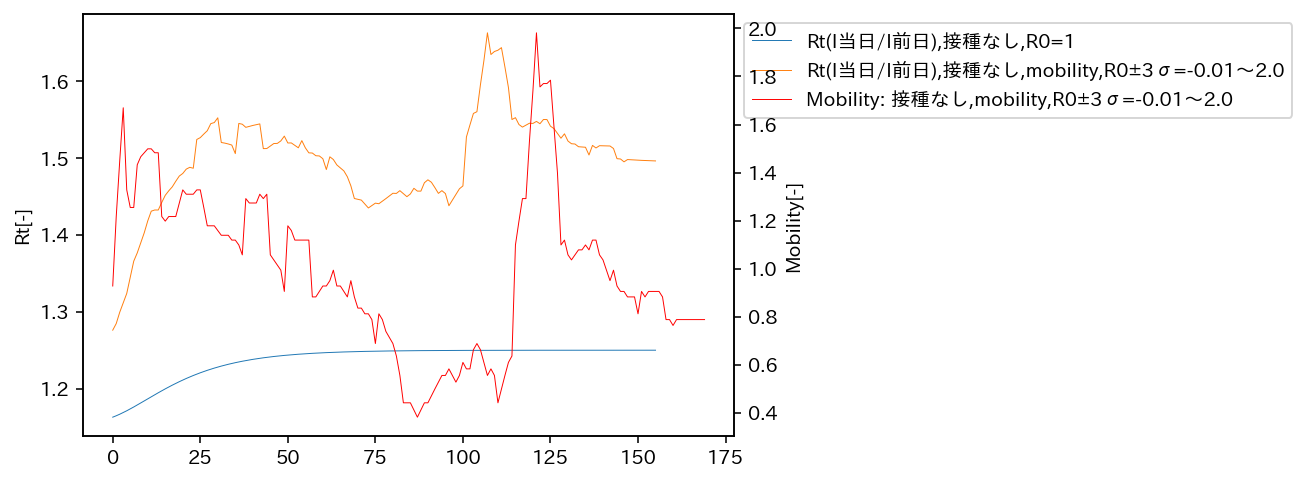

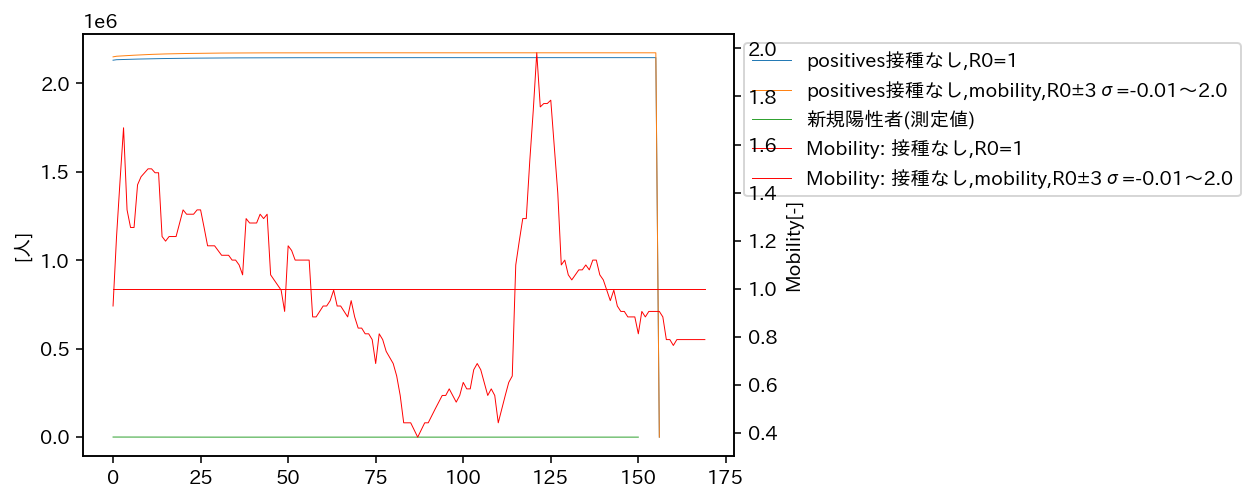

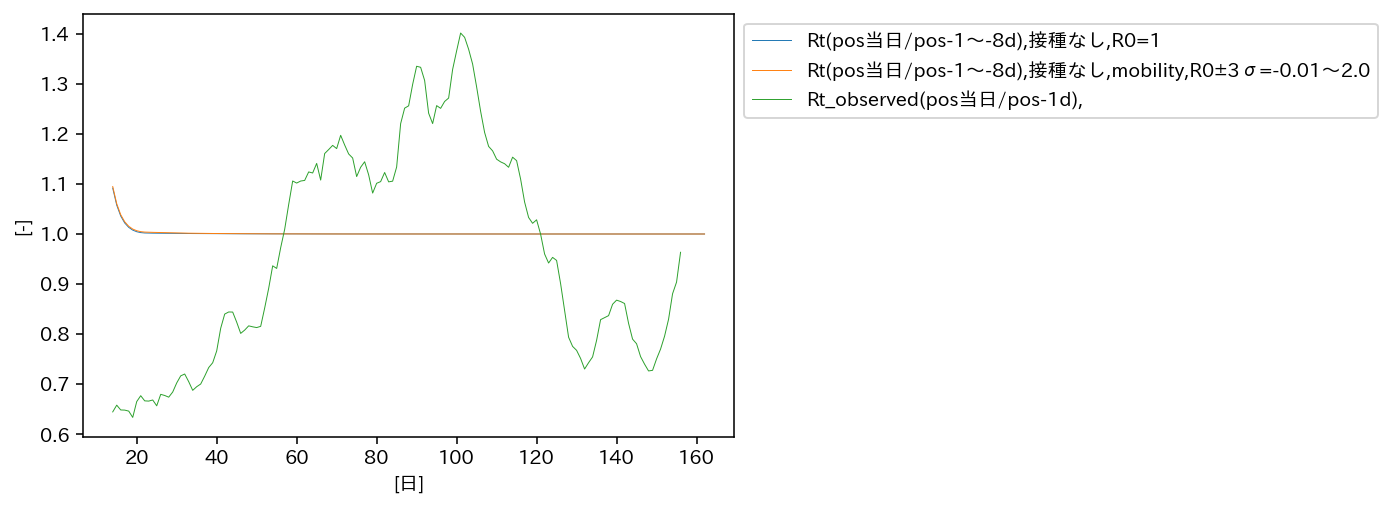

In [ ]:
# two data plot
def plotdiff(datas):
    plt.rcParams["figure.dpi"]=140
    class Localdata:
        pass
    ds=[]
    for i, d in enumerate(datas):
        ds.append(Localdata())
        ds[i].S=d.S.values
        ds[i].E=d.E.values
        ds[i].I=d.I.values
        ds[i].R=d.R.values
        ds[i].Q=d.Q.values
        ds[i].C=d.C.values
        ds[i].V=d.V.values
        ds[i].positives=d.E.out
        ds[i].positives_target=d.positives_target
        ds[i].dV=d.V.d
        ds[i].dI=d.I.d
        ds[i].dC=d.C.d
        ds[i].N=d.N
        ds[i].NUM_OF_CALCULATED_DAYS=d.NUM_OF_CALCULATED_DAYS
        ds[i].NUM_OF_DAYS=d.NUM_OF_DAYS
        ds[i].label=d.label
        ds[i].mobility=d.mobility
        ds[i].T=range(14,ds[-1].NUM_OF_CALCULATED_DAYS+1)
    #print("NUM_OF_DAYS:",ds[-1].NUM_OF_DAYS)
    #print("NUM_OF_CALCULATED_DAYS:",ds[-1].NUM_OF_CALCULATED_DAYS)
    #print("len(S)",len(ds[0].S))

    for _, d in enumerate(ds):
        plt.plot(range(14,len(d.E)),[np.sum(i) for i in d.E[14:]], label="E"+d.label, linewidth=.5)
        plt.plot(range(14,len(d.I)),[np.sum(i) for i in d.I[14:]], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(i) for i in d.Q], label="Q"+d.label, linewidth=.5)
        #plt.plot([np.sum(c) for c in d.C], label="Critical"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in d.T], label="E+I+Q+C合計,"+d.label, linewidth=.5)
        plt.plot([np.sum(d.positives[t]) for t in d.T], label="positives "+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t]) for t in d.T], label="I "+d.label, linewidth=.5)
        #for k, age in enumerate(GROUPS):
            #plt.plot([s[k] for s in d.S], label="S"+d.label, linewidth=.5)
            #plt.plot([r[k] for r in d.R], label="R"+d.label, linewidth=.5)
            #plt.plot([d.E[t][k]+d.I[t][k]+d.Q[t][k]+d.C[t][k] for t in d.T], label="E+I+Q+C合計,"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot(range(14,len(d.S)),[np.sum(s) for s in d.S[14:]]/sum(d.N), label="S"+d.label, linewidth=.5)
        plt.plot(range(14,len(d.V)),[np.sum(v) for v in d.V[14:]]/sum(d.N), label="V"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.I], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.C[t])+sum(d.I[t]) for t in T], label="I+C"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.C[t])+sum(d.Q[t])+sum(d.V[t]) for t in T], label="SIRCQV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("全人口に占める割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.positives[t-6:t])/np.sum(d.positives[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(新規陽性当日〜7日前までの平均/新規陽性7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t-6:t])/np.sum(d.I[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(I当日〜7日前までの平均/I前の7〜13日前平均),"+d.label, linewidth=.5)
        ax1.plot([np.sum(d.I[t])/np.sum(d.I[t-1]*d.S[t-1]/d.N) for t in d.T], label="Rt(I当日/I前日),"+d.label, linewidth=.5)
    ax2.plot(ds[1].mobility, color="red",label="Mobility: "+ds[1].label, linewidth=.5)
    plt.xlabel("[日]")
    ax1.set_ylabel("Rt[-]")
    ax2.set_ylabel("Mobility[-]")
    hand1, label1 = ax1.get_legend_handles_labels()
    hand2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(hand1 + hand2, label1 + label2,bbox_to_anchor=(1,1))
    plt.show()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    for i, d in enumerate(ds):
        #plt.plot([np.sum(m) for m in d.I], label="I"+d.label, linewidth=.5)
        ax1.plot([np.sum(m) for m in d.positives[14:]], label="positives"+d.label, linewidth=.5)
        #plt.plot([np.sum(m) for m in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in T], label="E+I+Q+C合計", linewidth=.5)
        ax2.plot(d.mobility, color="red",label="Mobility: "+d.label, linewidth=.5)
    ax1.plot([np.sum(m) for m in ds[1].positives_target[14:]], label="新規陽性者(測定値)", linewidth=.5)
    plt.xlabel("[日]")
    ax1.set_ylabel("[人]")
    ax2.set_ylabel("Mobility[-]")
    hand1, label1 = ax1.get_legend_handles_labels()
    hand2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(hand1 + hand2, label1 + label2,bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.positives[t-6:t])/np.sum(d.positives[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(新規陽性当日〜7日前までの平均/新規陽性7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t-6:t])/np.sum(d.I[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(I当日〜7日前までの平均/I前の7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t])/np.sum(d.I[t-1]*d.S[t-1]/d.N) for t in range(1,d.NUM_OF_CALCULATED_DAYS)], label="Rt(pos当日/pos-1〜-8d),"+d.label, linewidth=.5)
        plt.plot(range(14,len(d.positives)-8),[np.sum(d.positives[t:t+7])/np.sum(d.positives[t-8:t-1]) for t in range(14,len(d.positives)-8)], label="Rt(pos当日/pos-1〜-8d),"+d.label, linewidth=.5)
    plt.plot(range(14,len(d.positives_target)-8),[np.sum(ds[0].positives_target[t:t+7])/np.sum(ds[0].positives_target[t-8:t-1]) for t in range(14,len(d.positives_target)-8)], label="Rt_observed(pos当日/pos-1d),", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

plotdiff(datas)


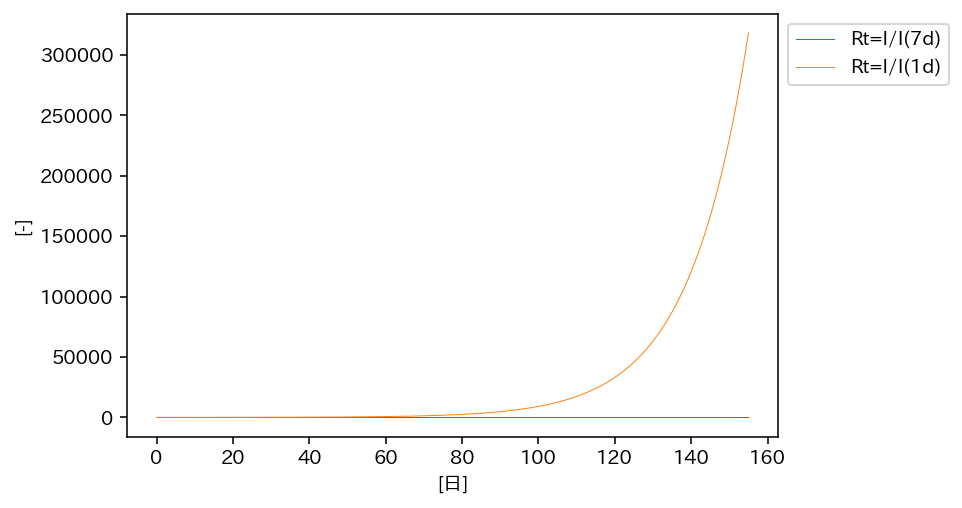

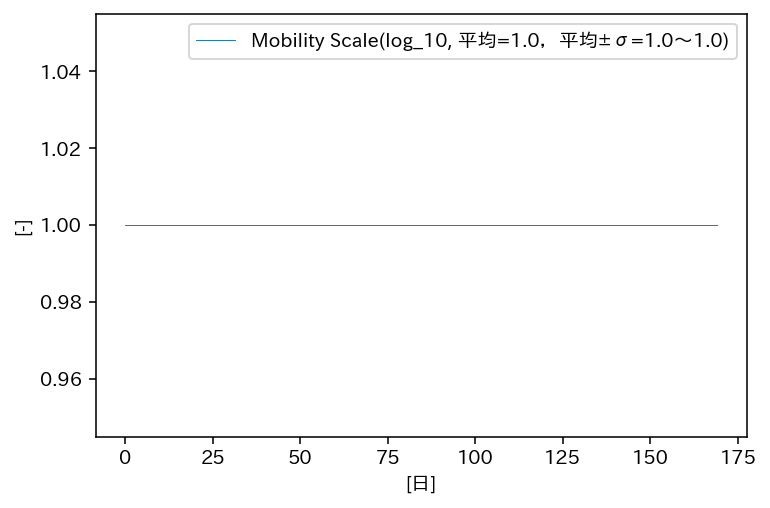

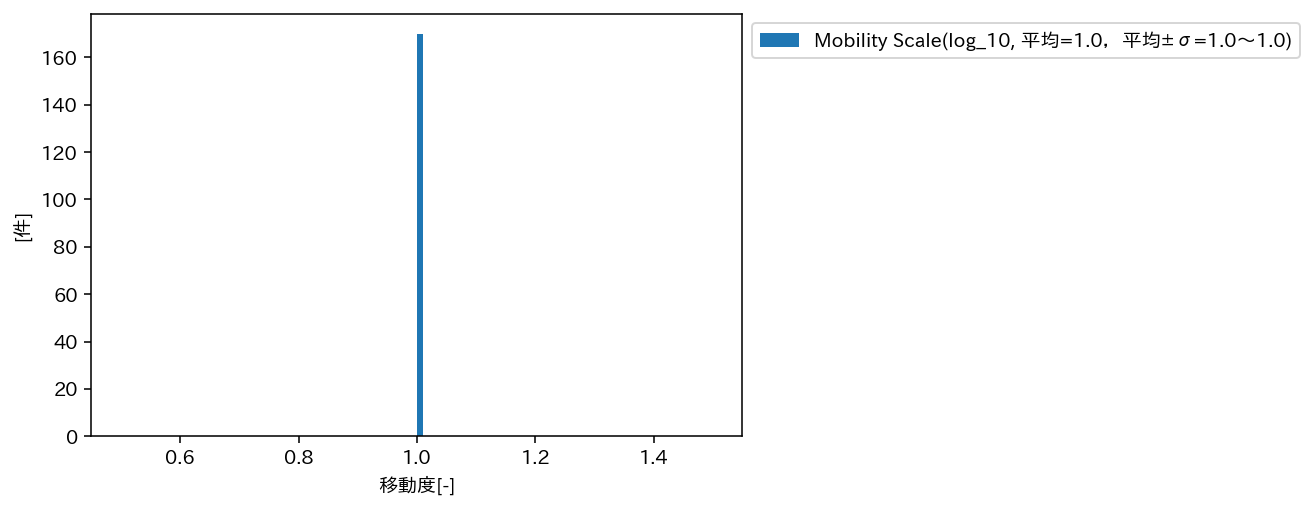

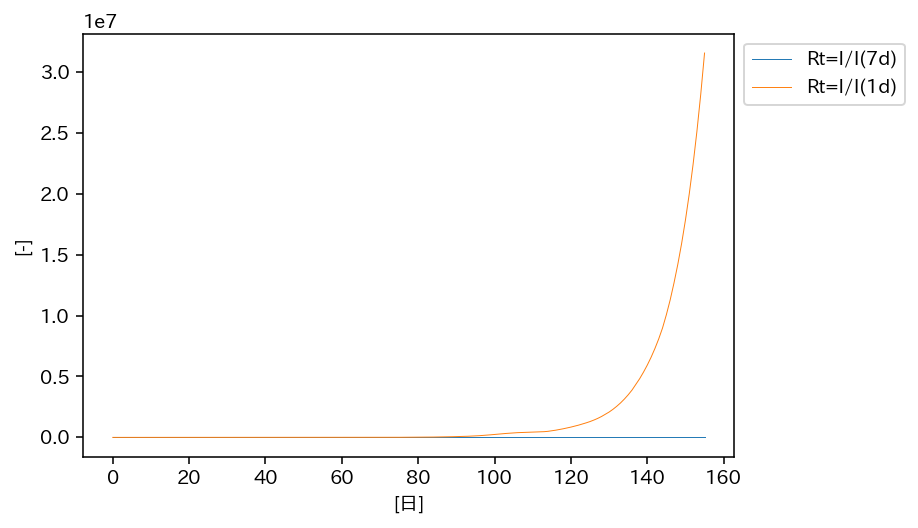

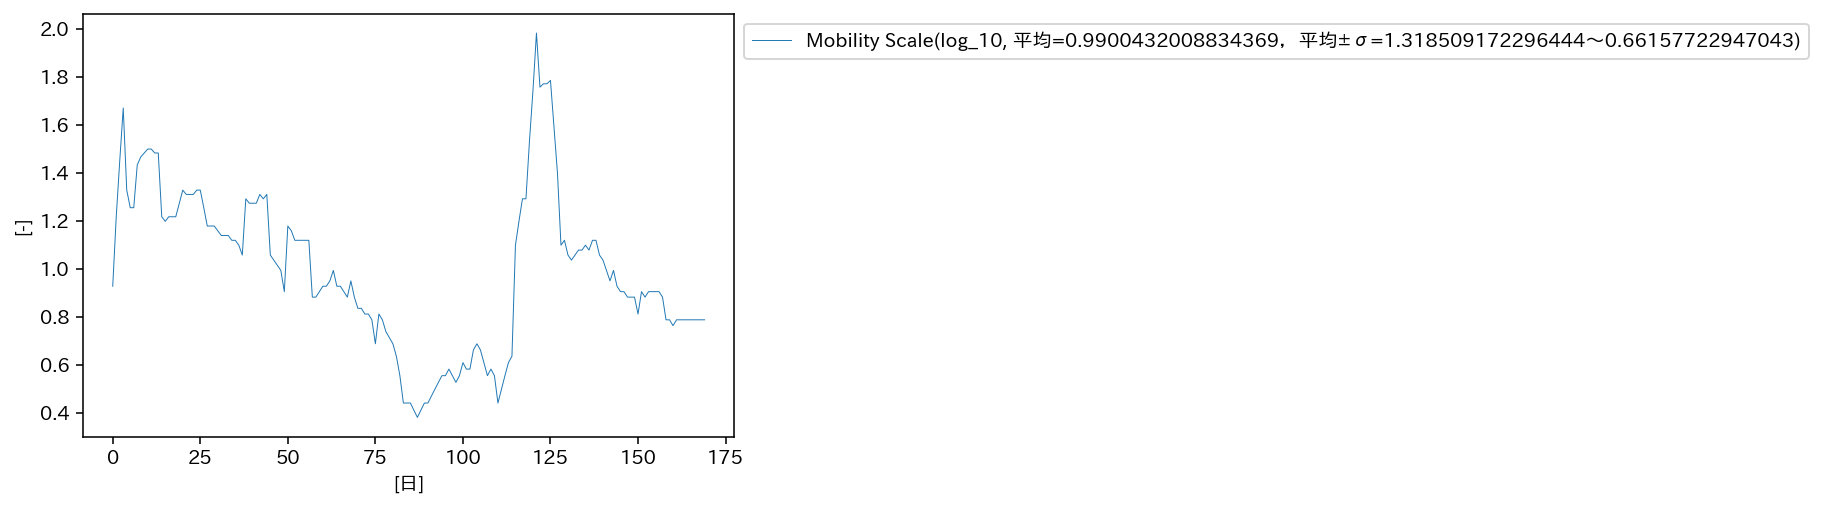

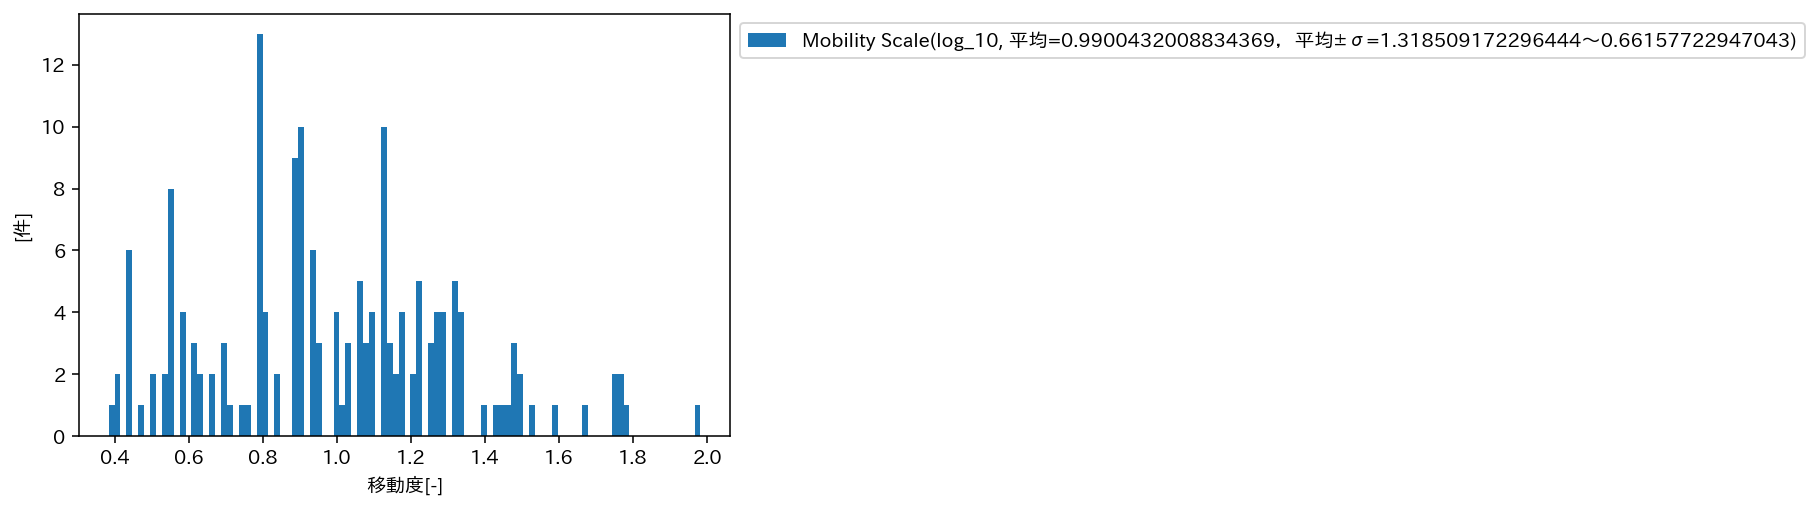

In [ ]:
# plot
def plot2(d):
    plt.rcParams["figure.dpi"]=140
    N=d.N
    S=d.S.values
    E=d.E.values
    I=d.I.values
    R=d.R.values
    Q=d.Q.values
    C=d.C.values
    V=d.V.values

    positives=d.positives

    all=d.pipeline
    before=d.before
    patient=d.patient
    after=d.after

    dS=d.S.d
    dSin=d.S.input
    dSout=d.S.out
    dI=d.I.d
    dIin=d.I.input
    dIout=d.I.out
    dE=d.E.d
    dEin=d.E.input
    dEout=d.E.out
    dR=d.R.d
    dQ=d.Q.d
    dC=d.C.d
    dCin=d.C.input
    dCout=d.C.out
    dV=d.V.d
    dVin=d.V.input
    dVout=d.V.out

    mobility=d.mobility

    T=range(0,d.NUM_OF_CALCULATED_DAYS+1)

    #def print_len():
        #print("NUM_OF_DAYS:",d.NUM_OF_DAYS)
        #print("NUM_OF_CALCULATED_DAYS:",d.NUM_OF_CALCULATED_DAYS)
        #print("len(S)",len(S))
        #print("len(I)",len(I))
        #print("len(E)",len(E))
        #print("len(R)",len(R))
        #print("len(Q)",len(Q))
        #print("len(C)",len(C))
        #print("len(V)",len(V))
        #print("len(dV)",len(dV))
        #print("sum(S[-1])",sum(S[-1]))
        #print("sum(I[-1])",sum(I[-1]))
        #print("sum(R[-1])",sum(R[-1]))
        #print("sum(Q[-1])",sum(Q[-1]))
        #print("sum(C[-1])",sum(C[-1]))
        #print("sum(V[-1])",sum(V[-1]))
        #print("sum(dV[-1])",sum(dV[-1]))
    #print_len()

    #for k, age in enumerate(GROUPS):
    plt.plot([np.sum(I[t])/np.sum(I[t-8:t-1])*7 for t in range(14,d.NUM_OF_CALCULATED_DAYS+1)], label="Rt=I/I(7d)", linewidth=.5)
    plt.plot([np.sum(positives[t])/np.sum(I[t-1])*7 for t in range(14,d.NUM_OF_CALCULATED_DAYS+1)], label="Rt=I/I(1d)", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #print("np.average(mobility)=",np.average(mobility))
    #print("np.std(mobility)=",np.std(mobility))
    plt.plot(mobility, label="Mobility Scale(log_10, 平均="+str(np.average(mobility))+"，平均±σ="+str(np.average(mobility)+np.std(mobility))+"〜"+str(np.average(mobility)-np.std(mobility))+")", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


    plt.hist(mobility, bins=100, label="Mobility Scale(log_10, 平均="+str(np.average(mobility))+"，平均±σ="+str(np.average(mobility)+np.std(mobility))+"〜"+str(np.average(mobility)-np.std(mobility))+")")
    plt.xlabel("移動度[-]")
    plt.ylabel("[件]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

for d in datas:
    #print(d.label)
    plot2(d)
